### Extração, Transformação e Carga do conjunto de dados

O arquivo m_3330.csv utilizado neste trabalho foi previamente tratado conforme explicado aqui:
https://github.com/dssantos/alibaba-datacenter-workload/blob/main/extract_transform_load.ipynb

### Importação das bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

### Conjunto de dados

In [2]:
# Carrega o conjunto de dados, ajusta o intervalo de tempo em 5 minuto
# e retorna os registros de CPU dos últimos 3 dias

def dataframe(file):
    df = pd.read_csv(file, 
                 names = ['machine_id', 'time_stamp', 'cpu', 'mem', 'mem_gps', 
                          'mkpi', 'net_in', 'net_out', 'disk_io_percent'])
    df.time_stamp = pd.to_datetime(df.time_stamp, unit='s')
    df.set_index('time_stamp', inplace=True)
    df = df.resample('5min').interpolate()
    df = df[-12*24*3:] # 5min * 12 * 24 * 3 = 3 days
    
    return df[['cpu']]

workload103 = dataframe('m_103.csv')
workload694 = dataframe('m_694.csv')
workload3330 = dataframe('m_3330.csv')

In [3]:
workload103

,cpu
time_stamp,
1970-01-06 00:00:00,17.0
1970-01-06 00:05:00,15.0
1970-01-06 00:10:00,26.0
1970-01-06 00:15:00,14.0
1970-01-06 00:20:00,21.0
...,...
1970-01-08 23:35:00,14.0
1970-01-08 23:40:00,16.0
1970-01-08 23:45:00,12.0


In [4]:
workload694

,cpu
time_stamp,
1970-01-06 00:00:00,25.0
1970-01-06 00:05:00,31.0
1970-01-06 00:10:00,34.0
1970-01-06 00:15:00,31.0
1970-01-06 00:20:00,32.0
...,...
1970-01-08 23:35:00,86.0
1970-01-08 23:40:00,86.0
1970-01-08 23:45:00,85.0


In [5]:
workload3330

,cpu
time_stamp,
1970-01-06 00:00:00,26.0
1970-01-06 00:05:00,27.0
1970-01-06 00:10:00,38.0
1970-01-06 00:15:00,30.0
1970-01-06 00:20:00,33.0
...,...
1970-01-08 23:35:00,21.0
1970-01-08 23:40:00,25.0
1970-01-08 23:45:00,19.0


### Uso de CPU

<AxesSubplot:xlabel='time_stamp'>

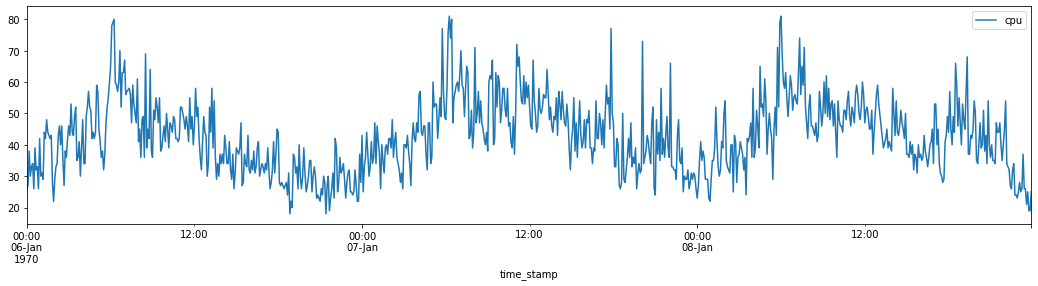

In [6]:
workload3330.plot(figsize=(18,4))

<AxesSubplot:xlabel='time_stamp'>

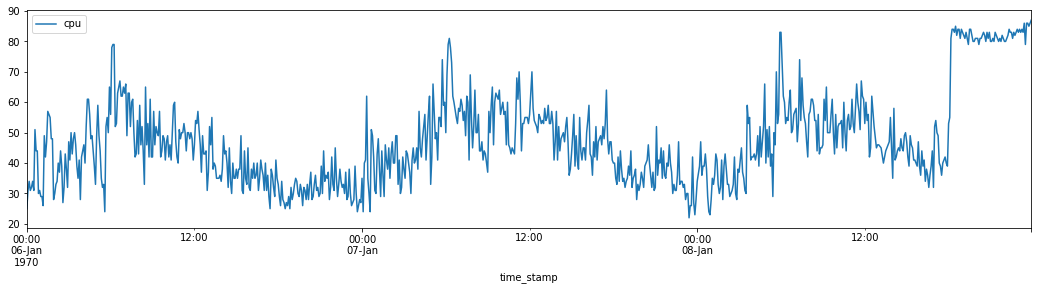

In [7]:
workload694.plot(figsize=(18,4))

<AxesSubplot:xlabel='time_stamp'>

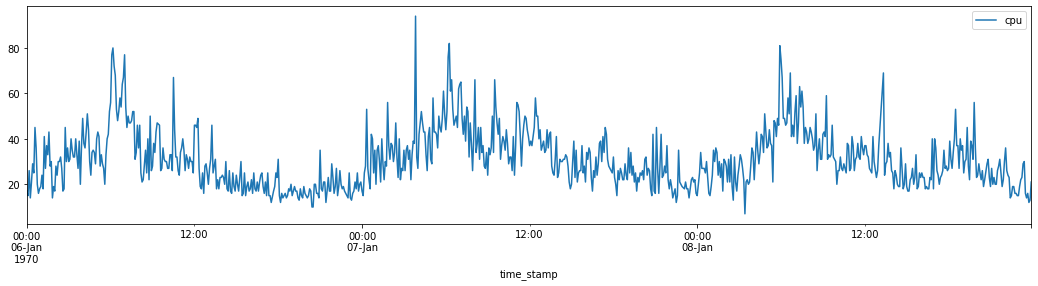

In [8]:
workload103.plot(figsize=(18,4))

### Análise da série temporal

In [9]:
# Verifica se a média é constante ao longo do tempo (característica estacionária)

workload3330['mean'] = [np.mean(workload3330.cpu[:x]) for x in range(len(workload3330.cpu))]
workload694['mean'] = [np.mean(workload694.cpu[:x]) for x in range(len(workload694.cpu))]
workload103['mean'] = [np.mean(workload103.cpu[:x]) for x in range(len(workload103.cpu))]

Text(0.5, 0, 'tempo')

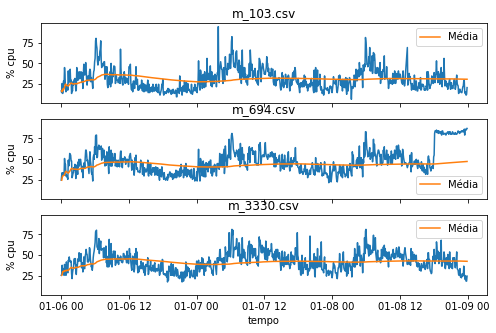

In [10]:
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(8,5))
axs[0].set_title('m_103.csv')
axs[0].plot(workload103['cpu'])
axs[0].plot(workload103['mean'], label="Média")
axs[0].set(ylabel="% cpu")
axs[0].legend()
axs[1].set_title('m_694.csv')
axs[1].plot(workload694['cpu'])
axs[1].plot(workload694['mean'], label="Média")
axs[1].set(ylabel="% cpu")
axs[1].legend()
axs[2].set_title('m_3330.csv')
axs[2].plot(workload3330['cpu'])
axs[2].plot(workload3330['mean'], label="Média")
axs[2].set(ylabel="% cpu")
axs[2].legend()
plt.xlabel('tempo')

In [11]:
# Usando o teste Augmented Dickey-Fuller para obter o Valor-P
# O método adfuller retorna uma tupla cujo segundo item é o Valor-P
# Caso o Valor-P seja inferior a 5%, então a série é estacionária

for host in [workload103, workload694, workload3330]:
    machine = host.iloc[0,0]
    result = adfuller(host['cpu'])

    print(f'\n{machine}')
    print(f'adf: {result[0]:.2f}')
    print(f'pvalue: {result[1]:.2f}')
    print(f'usedlag: {result[2]:.2f}')
    print(f'nobs: {result[3]:.2f}')
    for key, value in result[4].items():
        print(f'{key} critical value: {value:.2f}')
    print(f'icbest: {result[5]:.2f}')


17.0
adf: -3.54
pvalue: 0.01
usedlag: 8.00
nobs: 855.00
1% critical value: -3.44
5% critical value: -2.86
10% critical value: -2.57
icbest: 5974.58

25.0
adf: -1.51
pvalue: 0.53
usedlag: 11.00
nobs: 852.00
1% critical value: -3.44
5% critical value: -2.86
10% critical value: -2.57
icbest: 5689.72

26.0
adf: -2.73
pvalue: 0.07
usedlag: 15.00
nobs: 848.00
1% critical value: -3.44
5% critical value: -2.86
10% critical value: -2.57
icbest: 5851.50


### Separar conjuntos de treino e  teste

In [12]:
test_perc = 1/3
test_len = int(len(workload3330)*test_perc)

train3330 = workload3330.iloc[:-test_len] # Conjunto de treino
test3330 = workload3330.iloc[-test_len:]  # Conjunto de teste

train694 = workload694.iloc[:-test_len] # Conjunto de treino
test694 = workload694.iloc[-test_len:]  # Conjunto de teste

train103 = workload103.iloc[:-test_len] # Conjunto de treino
test103 = workload103.iloc[-test_len:]  # Conjunto de teste


Text(0.5, 0, 'tempo')

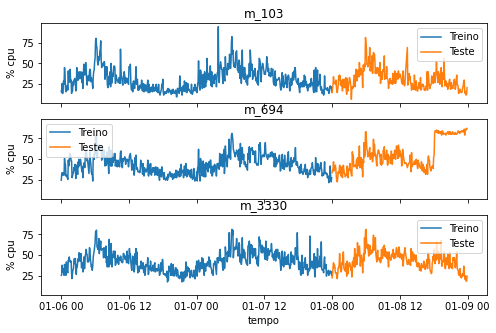

In [13]:
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(8,5))
axs[0].set_title('m_103')
axs[0].plot(train103.cpu, label="Treino")
axs[0].plot(test103.cpu, label="Teste")
axs[0].set(ylabel="% cpu")
axs[0].legend()
axs[1].set_title('m_694')
axs[1].plot(train694.cpu, label="Treino")
axs[1].plot(test694.cpu, label="Teste")
axs[1].set(ylabel="% cpu")
axs[1].legend()
axs[2].set_title('m_3330')
axs[2].plot(train3330.cpu, label="Treino")
axs[2].plot(test3330.cpu, label="Teste")
axs[2].set(ylabel="% cpu")
axs[2].legend()
plt.xlabel('tempo')